# All plots

## Time difference between AE, PS and S2

C:\Users\castad001\AppData\Local\Temp\ipykernel_23072\1171851335.py:156: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  p["x0_days"] = mdates.date2num(p["time"].dt.to_pydatetime())


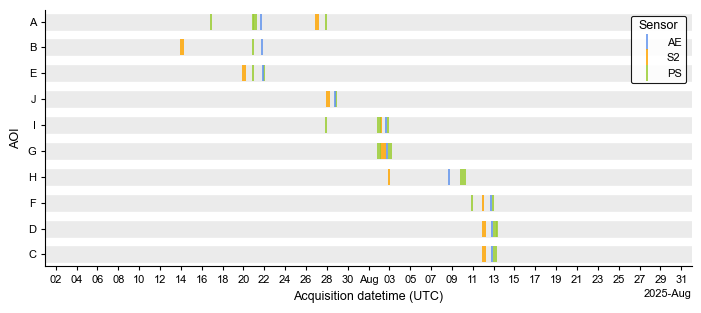


S2 vs nearest AE (Aerial): per AOI stats (hours)
  signed: sensor_time - aerial_time  (+: sensor after AE)
  abs: |sensor_time - aerial_time|
                AOI  count  mean_signed  median_signed  min_signed  max_signed  mean_abs  median_abs  min_abs  max_abs
      DWChannelWest      1       -17.95         -17.95      -17.95      -17.95     17.95       17.95    17.95    17.95
    DriftwoodFields      2      -186.50        -186.50     -186.50     -186.50    186.50      186.50   186.50   186.50
DriftwoodInnerDelta      2       -44.03         -44.03      -44.03      -44.03     44.03       44.03    44.03    44.03
     DriftwoodKitti      1      -136.93        -136.93     -136.93     -136.93    136.93      136.93   136.93   136.93
       DriftwoodTuk      2       -17.88         -17.88      -17.88      -17.88     17.88       17.88    17.88    17.88
         KittiCoast      1       -16.70         -16.70      -16.70      -16.70     16.70       16.70    16.70    16.70
       MackenzieSub     

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import geopandas as gpd

# =============================================================================
# RSE / publication-style CONFIG
# =============================================================================
FIG_WIDTH_MM = 180
FIG_MIN_HEIGHT_IN = 3.2
FIG_ROW_HEIGHT_IN = 0.30

FONT_FAMILY = "Arial"
BASE_FONTSIZE = 9
LABEL_FONTSIZE = 9
TICK_FONTSIZE = 8
LEGEND_FONTSIZE = 8

AXES_LINEWIDTH = 0.8
TICK_WIDTH = 0.8
TICK_LENGTH = 3.0

STRIPE_COLOR = "0.92"
STRIPE_LINEWIDTH = 12
STRIPE_ALPHA = 1.0

MARKER_STYLE = "|"
MARKER_SIZE = 12
MARKER_EDGEWIDTH = 1.25

X_TICK_DAY_INTERVAL = 2

OUT_DIR = "./figs"
OUT_BASE = "AQC_times_RSE"
SAVE_PNG = True
PNG_DPI = 600
SAVE_PDF = True

LEGEND_LABEL_MAP = {
    "Sentinel-2": "S2",
    "Aerial": "AE",
    "AE": "AE",
}
LEGEND_ORDER = {"AE": 0, "S2": 1, "PS": 2, "Other": 99}

# =============================================================================
# Matplotlib rcParams
# =============================================================================
plt.rcParams.update({
    "font.family": FONT_FAMILY if FONT_FAMILY else "DejaVu Sans",
    "font.size": BASE_FONTSIZE,
    "axes.labelsize": LABEL_FONTSIZE,
    "xtick.labelsize": TICK_FONTSIZE,
    "ytick.labelsize": TICK_FONTSIZE,
    "legend.fontsize": LEGEND_FONTSIZE,
    "axes.linewidth": AXES_LINEWIDTH,
    "xtick.major.width": TICK_WIDTH,
    "ytick.major.width": TICK_WIDTH,
    "xtick.major.size": TICK_LENGTH,
    "ytick.major.size": TICK_LENGTH,
    "savefig.bbox": "tight",
    "figure.facecolor": "white",
    "axes.facecolor": "white",
})

def mm_to_in(mm: float) -> float:
    return mm / 25.4


# =============================================================================
# Collision-avoidance: shift x only when visually colliding (plot-only)
# =============================================================================
def _spread_1d_with_min_sep(x0, min_sep, lower, upper, n_iter=6, pull=0.35):
    """
    Given 1D positions x0, find adjusted positions x that satisfy spacing >= min_sep.
    Uses forward/backward constraint passes and a gentle pull back toward original positions.
    Works in continuous units (here: matplotlib date numbers in DAYS).
    """
    x0 = np.asarray(x0, dtype=float)
    if x0.size <= 1:
        return x0.copy()

    order = np.argsort(x0)
    x_orig = x0[order]
    x_adj = x_orig.copy()

    for _ in range(n_iter):
        # forward enforce
        for i in range(1, len(x_adj)):
            if x_adj[i] - x_adj[i - 1] < min_sep:
                x_adj[i] = x_adj[i - 1] + min_sep

        # backward enforce
        for i in range(len(x_adj) - 2, -1, -1):
            if x_adj[i + 1] - x_adj[i] < min_sep:
                x_adj[i] = x_adj[i + 1] - min_sep

        # keep within bounds by shifting the whole set (preserves spacings)
        if x_adj[0] < lower:
            x_adj += (lower - x_adj[0])
        if x_adj[-1] > upper:
            x_adj += (upper - x_adj[-1])

        # pull toward original (then next loop re-enforces constraints)
        x_adj = x_adj + pull * (x_orig - x_adj)

    # final hard enforce + bounds
    for i in range(1, len(x_adj)):
        if x_adj[i] - x_adj[i - 1] < min_sep:
            x_adj[i] = x_adj[i - 1] + min_sep
    for i in range(len(x_adj) - 2, -1, -1):
        if x_adj[i + 1] - x_adj[i] < min_sep:
            x_adj[i] = x_adj[i + 1] - min_sep

    if x_adj[0] < lower:
        x_adj += (lower - x_adj[0])
    if x_adj[-1] > upper:
        x_adj += (upper - x_adj[-1])

    out = np.empty_like(x0)
    out[order] = x_adj
    return out


def dodge_colliding_ticks_by_aoi(points: pd.DataFrame, ax, fig,
                                 window_start: pd.Timestamp, window_end: pd.Timestamp,
                                 marker_edgewidth_pts: float,
                                 safety_factor: float = 1.10) -> pd.DataFrame:
    """
    Compute x_plot for each point by AOI:
    - determine min separable distance in *days* based on:
      marker edgewidth in points, axis width in points, and the x-range in days
    - spread points within each AOI to satisfy that min spacing
    """
    p = points.copy()
    p = p.dropna(subset=["AOI", "time"]).copy()
    p["time"] = pd.to_datetime(p["time"], errors="coerce")
    p = p.dropna(subset=["time"]).copy()

    # Need a drawn canvas to get accurate axis width after layout
    fig.canvas.draw()
    ax_box = ax.get_window_extent()  # pixels
    axis_width_points = ax_box.width * 72.0 / fig.dpi

    x_min = mdates.date2num(pd.Timestamp(window_start).to_pydatetime())
    x_max = mdates.date2num(pd.Timestamp(window_end).to_pydatetime())
    x_range_days = float(x_max - x_min)

    # Marker width (points) -> min spacing in days
    # Using safety_factor slightly > 1 avoids "still touching" due to antialiasing.
    min_sep_points = float(marker_edgewidth_pts) * float(safety_factor)
    min_sep_days = (min_sep_points / max(axis_width_points, 1e-9)) * x_range_days

    p["x0_days"] = mdates.date2num(p["time"].dt.to_pydatetime())

    # Apply spreading within each AOI
    x_adj = np.empty(len(p), dtype=float)
    for aoi, g in p.groupby("AOI", sort=False):
        idx = g.index.to_numpy()
        x0 = g["x0_days"].to_numpy()
        x1 = _spread_1d_with_min_sep(x0, min_sep_days, x_min, x_max)
        x_adj[p.index.get_indexer(idx)] = x1  # fill aligned to p order

    # Convert adjustment back into datetimes without timezone weirdness:
    dx_days = x_adj - p["x0_days"].to_numpy()
    p["x_plot"] = p["time"] + pd.to_timedelta(dx_days, unit="D")
    return p


# =============================================================================
# --- Load ---
# =============================================================================
csv_path = r"\\smb.isipd.dmawi.de\projects\p_planetdw\data\methods_test\aois\S2_GEE_export_summary.csv"
ps_csv_path = r"\\smb.isipd.dmawi.de\projects\p_planetdw\data\methods_test\aois\PSScene_used_selection_summary.csv"
gpkg_path = r"\\smb.isipd.dmawi.de\projects\p_planetdw\data\methods_test\auxilliary_data\aoi_ext.gpkg"

df = pd.read_csv(csv_path)
ps_df = pd.read_csv(ps_csv_path)

# guard against duplicate columns from messy CSV exports
df = df.loc[:, ~df.columns.duplicated()].copy()
ps_df = ps_df.loc[:, ~ps_df.columns.duplicated()].copy()

# GeoPandas: avoid ignore_geometry=True (not supported in many versions)
aerialaq = gpd.read_file(gpkg_path)
aerialaq = aerialaq.drop(columns="geometry", errors="ignore")

# =============================================================================
# --- NEW: AOI -> alpha mapping for y-axis labels ---
# =============================================================================
# Use target_name as the AOI key; alpha becomes the y tick label.
# Falls back to AOI name if alpha missing.
if "target_name" in aerialaq.columns:
    aerialaq["target_name"] = aerialaq["target_name"].astype(str).str.strip()

if "alpha" in aerialaq.columns and "target_name" in aerialaq.columns:
    _alpha_map = (
        aerialaq[["target_name", "alpha"]]
        .dropna(subset=["target_name", "alpha"])
        .drop_duplicates(subset=["target_name"])
        .set_index("target_name")["alpha"]
    )
else:
    _alpha_map = pd.Series(dtype=object)

def aoi_label(aoi: str) -> str:
    v = _alpha_map.get(aoi, np.nan)
    return str(v) if pd.notna(v) else str(aoi)


# =============================================================================
# --- Aerial (GPKG): build datetime ---
# =============================================================================
aerialaq["Date"] = aerialaq["layer"].astype(str).str.split("_").str[2]
aerialaq["Date"] = pd.to_datetime(aerialaq["Date"], format="%Y%m%d", errors="coerce")
aerialaq["time"] = aerialaq["time"].astype(str).str.strip()

aerialaq["DateTime"] = pd.to_datetime(
    aerialaq["Date"].dt.strftime("%Y-%m-%d") + " " + aerialaq["time"],
    utc=True,
    errors="coerce",
).dt.tz_convert(None)

# =============================================================================
# --- S2/Other CSV datetime ---
# =============================================================================
df["Date"] = pd.to_datetime(df["Date"], utc=True, errors="coerce").dt.tz_convert(None)

# --- PS datetime ---
ps_df["Date"] = pd.to_datetime(ps_df["Acquired"], utc=True, errors="coerce").dt.tz_convert(None)
ps_df["Sensor"] = "PS"

df["DateDeltaDays"] = pd.to_numeric(df.get("DateDeltaDays", 0), errors="coerce").fillna(0)
ps_df["DateDeltaDays"] = pd.to_numeric(ps_df.get("DateDeltaDays", 0), errors="coerce").fillna(0)

def infer_sensor(row):
    s = " ".join(str(row.get(c, "")) for c in ["ExportTask", "SystemIndex"]).upper()
    if ("_AE" in s) or ("AE_" in s) or (" AE " in s):
        return "AE"
    if "AERIAL" in s:
        return "Aerial"
    if ("S2" in s) or ("SENTINEL-2" in s) or ("SENTINEL2" in s):
        return "Sentinel-2"
    return "Other"

if "Sensor" not in df.columns:
    df["Sensor"] = df.apply(infer_sensor, axis=1)

# Drop Aerial coming from the CSV: only use Aerial from GPKG
df = df[df["Sensor"] != "Aerial"].copy()

df["plot_date"] = df["Date"]
ps_df["plot_date"] = ps_df["Date"]

# =============================================================================
# Window
# =============================================================================
window_start = pd.Timestamp("2025-07-01 00:00")
window_end   = pd.Timestamp("2025-08-31 23:59")

df_plot = df[df["plot_date"].between(window_start, window_end)].copy()
ps_df_plot = ps_df[ps_df["plot_date"].between(window_start, window_end)].copy()

non_aerial_plot = pd.concat([df_plot, ps_df_plot], ignore_index=True)

aerial_points = aerialaq[aerialaq["DateTime"].between(window_start, window_end)].copy()
aerial_points["Sensor"] = "Aerial"

# =============================================================================
# AOI ordering (earliest aerial first, then earliest non-aerial)
# =============================================================================
aois_in_plot = non_aerial_plot["AOI"].dropna().unique()

aerial_min = (
    aerial_points[aerial_points["target_name"].isin(aois_in_plot)]
    .dropna(subset=["DateTime", "target_name"])
    .groupby("target_name")["DateTime"]
    .min()
)
aois_with_aerial = aerial_min.sort_values().index.tolist()

remaining_aois = [a for a in aois_in_plot if a not in aois_with_aerial]
if remaining_aois:
    remaining_min = (
        non_aerial_plot[non_aerial_plot["AOI"].isin(remaining_aois)]
        .groupby("AOI")["plot_date"]
        .min()
        .sort_values()
        .index
        .tolist()
    )
else:
    remaining_min = []

aoi_order = aois_with_aerial + remaining_min
aoi_to_y = {aoi: i for i, aoi in enumerate(aoi_order)}

# =============================================================================
# Figure (publication sizing)
# =============================================================================
fig_w_in = mm_to_in(FIG_WIDTH_MM)
fig_h_in = max(FIG_MIN_HEIGHT_IN, FIG_ROW_HEIGHT_IN * len(aoi_order))
fig, ax = plt.subplots(figsize=(fig_w_in, fig_h_in))

# stripes (old style)
for aoi in aoi_order:
    y = aoi_to_y[aoi]
    ax.hlines(
        y=y,
        xmin=window_start,
        xmax=window_end,
        color=STRIPE_COLOR,
        linewidth=STRIPE_LINEWIDTH,
        alpha=STRIPE_ALPHA,
        zorder=1,
    )

# Axes formatting BEFORE collision math (so layout/width are correct)
ax.set_yticks([aoi_to_y[a] for a in aoi_order])

# --- CHANGED: y-axis tick labels use alpha from GDF (fallback to AOI if missing) ---
ax.set_yticklabels([aoi_label(a) for a in aoi_order])

ax.invert_yaxis()
ax.set_xlim(window_start, window_end)

day_locator = mdates.DayLocator(interval=X_TICK_DAY_INTERVAL)
ax.xaxis.set_major_locator(day_locator)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(day_locator))

ax.set_xlabel("Acquisition datetime (UTC)")
ax.set_ylabel("AOI")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(direction="out")

# Tight layout now so axis width is final-ish (important for collision spacing)
fig.tight_layout()

# =============================================================================
# Build unified points table and dodge only when visually colliding
# =============================================================================
points_non = pd.DataFrame({
    "AOI": non_aerial_plot["AOI"].astype(str),
    "Sensor": non_aerial_plot["Sensor"].fillna("Other").astype(str),
    "time": non_aerial_plot["plot_date"],
}).dropna(subset=["AOI", "time"])

points_air = pd.DataFrame({
    "AOI": aerial_points["target_name"].astype(str),
    "Sensor": "Aerial",
    "time": aerial_points["DateTime"],
}).dropna(subset=["AOI", "time"])

points = pd.concat([points_non, points_air], ignore_index=True)

# Keep only AOIs actually in plot order
points = points[points["AOI"].isin(aoi_to_y)].copy()

# Compute x_plot with collision-aware dodging per AOI
points = dodge_colliding_ticks_by_aoi(
    points, ax=ax, fig=fig,
    window_start=window_start, window_end=window_end,
    marker_edgewidth_pts=MARKER_EDGEWIDTH,
    safety_factor=1.10,  # tweak 1.00..1.30 if you want more/less separation
)

# =============================================================================
# Plot points (old: same y for all sensors)
# =============================================================================
sensor_colors = {
    "Sentinel-2": "orange",
    "Aerial": "cornflowerblue",
    "AE": "cornflowerblue",
    "PS": "yellowgreen",
    "Other": "gray",
}

legend_done = set()
for sensor, g in points.groupby("Sensor", sort=False):
    color = sensor_colors.get(sensor, sensor_colors["Other"])
    label = sensor if sensor not in legend_done else "_nolegend_"
    y = g["AOI"].map(aoi_to_y).to_numpy()

    ax.plot(
        g["x_plot"].to_numpy(),
        y,
        marker=MARKER_STYLE,
        markersize=MARKER_SIZE,
        markeredgewidth=MARKER_EDGEWIDTH,
        linestyle="None",
        markerfacecolor="none",
        markeredgecolor=color,
        alpha=0.95,
        zorder=3,
        label=label,
    )
    legend_done.add(sensor)

# =============================================================================
# Legend (rename labels in legend only)
# =============================================================================
handles, labels = ax.get_legend_handles_labels()
labels = [LEGEND_LABEL_MAP.get(l, l) for l in labels]

uniq = {}
for h, l in zip(handles, labels):
    if l not in uniq:
        uniq[l] = h

sorted_labels = sorted(uniq.keys(), key=lambda x: LEGEND_ORDER.get(x, 50))
sorted_handles = [uniq[l] for l in sorted_labels]

leg = ax.legend(
    sorted_handles,
    sorted_labels,
    title="Sensor",
    loc="upper right",
    frameon=True,
    fancybox=True,
    framealpha=0.9,
    edgecolor="black",
    facecolor="white",
)
if leg is not None:
    leg.get_frame().set_linewidth(0.8)

# =============================================================================
# Save
# =============================================================================
os.makedirs(OUT_DIR, exist_ok=True)
if SAVE_PNG:
    fig.savefig(os.path.join(OUT_DIR, f"{OUT_BASE}.png"), dpi=PNG_DPI)
if SAVE_PDF:
    fig.savefig(os.path.join(OUT_DIR, f"{OUT_BASE}.pdf"))

plt.show()

# =============================================================================
# Stats: nearest aerial per acquisition (non-aerial only)
# =============================================================================
tmp_aerial = aerial_points.dropna(subset=["DateTime", "target_name"])[["target_name", "DateTime"]].copy()
tmp_aerial = tmp_aerial.rename(columns={"target_name": "AOI", "DateTime": "AerialDateTime"})

aerial_times_by_aoi = {
    aoi: times.sort_values().to_list()
    for aoi, times in tmp_aerial.groupby("AOI")["AerialDateTime"]
}

table = non_aerial_plot[["AOI", "Sensor", "plot_date"]].copy().sort_values(["AOI", "plot_date"])

def nearest_aerial(row):
    aoi = row["AOI"]
    t = row["plot_date"]
    times = aerial_times_by_aoi.get(aoi)
    if (times is None) or (len(times) == 0) or pd.isna(t):
        return pd.Series({"NearestAerial": pd.NaT, "Diff_hours": np.nan})

    diffs_sec = np.array([(t - a).total_seconds() for a in times])  # signed
    idx = int(np.argmin(np.abs(diffs_sec)))
    nearest_time = times[idx]
    diff_hours = diffs_sec[idx] / 3600.0
    return pd.Series({"NearestAerial": nearest_time, "Diff_hours": diff_hours})

table[["NearestAerial", "Diff_hours"]] = table.apply(nearest_aerial, axis=1)
table["Diff_hours"] = pd.to_numeric(table["Diff_hours"], errors="coerce")
table["Diff_hours_abs"] = table["Diff_hours"].abs()
table = table.rename(columns={"plot_date": "AcqDateTime"})

def sensor_vs_aerial_stats(table_df: pd.DataFrame, sensor_name: str):
    t = table_df[(table_df["Sensor"] == sensor_name) & table_df["NearestAerial"].notna()].copy()
    t = t.dropna(subset=["Diff_hours"])
    if t.empty:
        return None, None

    per_aoi = (
        t.groupby("AOI")
         .agg(
             count=("Diff_hours", "count"),
             mean_signed=("Diff_hours", "mean"),
             median_signed=("Diff_hours", "median"),
             min_signed=("Diff_hours", "min"),
             max_signed=("Diff_hours", "max"),
             mean_abs=("Diff_hours_abs", "mean"),
             median_abs=("Diff_hours_abs", "median"),
             min_abs=("Diff_hours_abs", "min"),
             max_abs=("Diff_hours_abs", "max"),
         )
         .reset_index()
         .sort_values("AOI")
    )
    overall = t.agg(
        count=("Diff_hours", "count"),
        mean_signed=("Diff_hours", "mean"),
        median_signed=("Diff_hours", "median"),
        min_signed=("Diff_hours", "min"),
        max_signed=("Diff_hours", "max"),
        mean_abs=("Diff_hours_abs", "mean"),
        median_abs=("Diff_hours_abs", "median"),
        min_abs=("Diff_hours_abs", "min"),
        max_abs=("Diff_hours_abs", "max"),
    )
    return per_aoi, overall

pd.set_option("display.float_format", lambda x: f"{x:6.2f}")

stats_s2_vs_ae, overall_s2_vs_ae = sensor_vs_aerial_stats(table, "Sentinel-2")
stats_ps_vs_ae, overall_ps_vs_ae = sensor_vs_aerial_stats(table, "PS")

print("\n========================================================")
print("S2 vs nearest AE (Aerial): per AOI stats (hours)")
print("  signed: sensor_time - aerial_time  (+: sensor after AE)")
print("  abs: |sensor_time - aerial_time|")
print("========================================================")
if stats_s2_vs_ae is None:
    print("No S2 rows with a nearest AE found in the selected window.")
else:
    print(stats_s2_vs_ae.to_string(index=False))
    print("\nS2 vs nearest AE: OVERALL stats")
    print(overall_s2_vs_ae)

print("\n========================================================")
print("PS vs nearest AE (Aerial): per AOI stats (hours)")
print("  signed: sensor_time - aerial_time  (+: sensor after AE)")
print("  abs: |sensor_time - aerial_time|")
print("========================================================")
if stats_ps_vs_ae is None:
    print("No PS rows with a nearest AE found in the selected window.")
else:
    print(stats_ps_vs_ae.to_string(index=False))
    print("\nPS vs nearest AE: OVERALL stats")
    print(overall_ps_vs_ae)

print("\n========================================================")
print("Per-acquisition nearest AE table (raw)")
print("========================================================")
print(
    table[["AOI", "Sensor", "AcqDateTime", "NearestAerial", "Diff_hours", "Diff_hours_abs"]]
    .to_string(index=False)
)


C:\Users\birgi\AppData\Local\Temp\ipykernel_26804\83383486.py:156: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  p["x0_days"] = mdates.date2num(p["time"].dt.to_pydatetime())


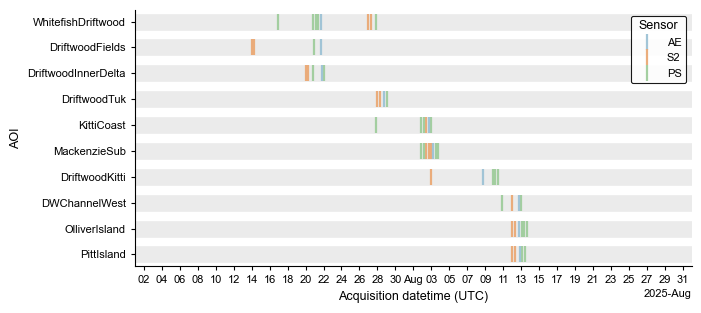


S2 vs nearest AE (Aerial): per AOI stats (hours)
  signed: sensor_time - aerial_time  (+: sensor after AE)
  abs: |sensor_time - aerial_time|
                AOI  count  mean_signed  median_signed  min_signed  max_signed  mean_abs  median_abs  min_abs  max_abs
      DWChannelWest      1       -17.95         -17.95      -17.95      -17.95     17.95       17.95    17.95    17.95
    DriftwoodFields      2      -186.50        -186.50     -186.50     -186.50    186.50      186.50   186.50   186.50
DriftwoodInnerDelta      2       -44.03         -44.03      -44.03      -44.03     44.03       44.03    44.03    44.03
     DriftwoodKitti      1      -136.93        -136.93     -136.93     -136.93    136.93      136.93   136.93   136.93
       DriftwoodTuk      2       -17.88         -17.88      -17.88      -17.88     17.88       17.88    17.88    17.88
         KittiCoast      1       -16.70         -16.70      -16.70      -16.70     16.70       16.70    16.70    16.70
       MackenzieSub     

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import geopandas as gpd

# =============================================================================
# RSE / publication-style CONFIG
# =============================================================================
FIG_WIDTH_MM = 180
FIG_MIN_HEIGHT_IN = 3.2
FIG_ROW_HEIGHT_IN = 0.30

FONT_FAMILY = "Arial"
BASE_FONTSIZE = 9
LABEL_FONTSIZE = 9
TICK_FONTSIZE = 8
LEGEND_FONTSIZE = 8

AXES_LINEWIDTH = 0.8
TICK_WIDTH = 0.8
TICK_LENGTH = 3.0

STRIPE_COLOR = "0.92"
STRIPE_LINEWIDTH = 12
STRIPE_ALPHA = 1.0

MARKER_STYLE = "|"
MARKER_SIZE = 12
MARKER_EDGEWIDTH = 1.6

X_TICK_DAY_INTERVAL = 2

OUT_DIR = "./figs"
OUT_BASE = "AQC_times_RSE"
SAVE_PNG = True
PNG_DPI = 600
SAVE_PDF = True

LEGEND_LABEL_MAP = {
    "Sentinel-2": "S2",
    "Aerial": "AE",
    "AE": "AE",
}
LEGEND_ORDER = {"AE": 0, "S2": 1, "PS": 2, "Other": 99}

# =============================================================================
# Matplotlib rcParams
# =============================================================================
plt.rcParams.update({
    "font.family": FONT_FAMILY if FONT_FAMILY else "DejaVu Sans",
    "font.size": BASE_FONTSIZE,
    "axes.labelsize": LABEL_FONTSIZE,
    "xtick.labelsize": TICK_FONTSIZE,
    "ytick.labelsize": TICK_FONTSIZE,
    "legend.fontsize": LEGEND_FONTSIZE,
    "axes.linewidth": AXES_LINEWIDTH,
    "xtick.major.width": TICK_WIDTH,
    "ytick.major.width": TICK_WIDTH,
    "xtick.major.size": TICK_LENGTH,
    "ytick.major.size": TICK_LENGTH,
    "savefig.bbox": "tight",
    "figure.facecolor": "white",
    "axes.facecolor": "white",
})

def mm_to_in(mm: float) -> float:
    return mm / 25.4


# =============================================================================
# Collision-avoidance: shift x only when visually colliding (plot-only)
# =============================================================================
def _spread_1d_with_min_sep(x0, min_sep, lower, upper, n_iter=6, pull=0.35):
    """
    Given 1D positions x0, find adjusted positions x that satisfy spacing >= min_sep.
    Uses forward/backward constraint passes and a gentle pull back toward original positions.
    Works in continuous units (here: matplotlib date numbers in DAYS).
    """
    x0 = np.asarray(x0, dtype=float)
    if x0.size <= 1:
        return x0.copy()

    order = np.argsort(x0)
    x_orig = x0[order]
    x_adj = x_orig.copy()

    for _ in range(n_iter):
        # forward enforce
        for i in range(1, len(x_adj)):
            if x_adj[i] - x_adj[i - 1] < min_sep:
                x_adj[i] = x_adj[i - 1] + min_sep

        # backward enforce
        for i in range(len(x_adj) - 2, -1, -1):
            if x_adj[i + 1] - x_adj[i] < min_sep:
                x_adj[i] = x_adj[i + 1] - min_sep

        # keep within bounds by shifting the whole set (preserves spacings)
        if x_adj[0] < lower:
            x_adj += (lower - x_adj[0])
        if x_adj[-1] > upper:
            x_adj += (upper - x_adj[-1])

        # pull toward original (then next loop re-enforces constraints)
        x_adj = x_adj + pull * (x_orig - x_adj)

    # final hard enforce + bounds
    for i in range(1, len(x_adj)):
        if x_adj[i] - x_adj[i - 1] < min_sep:
            x_adj[i] = x_adj[i - 1] + min_sep
    for i in range(len(x_adj) - 2, -1, -1):
        if x_adj[i + 1] - x_adj[i] < min_sep:
            x_adj[i] = x_adj[i + 1] - min_sep

    if x_adj[0] < lower:
        x_adj += (lower - x_adj[0])
    if x_adj[-1] > upper:
        x_adj += (upper - x_adj[-1])

    out = np.empty_like(x0)
    out[order] = x_adj
    return out


def dodge_colliding_ticks_by_aoi(points: pd.DataFrame, ax, fig,
                                 window_start: pd.Timestamp, window_end: pd.Timestamp,
                                 marker_edgewidth_pts: float,
                                 safety_factor: float = 1.10) -> pd.DataFrame:
    """
    Compute x_plot for each point by AOI:
    - determine min separable distance in *days* based on:
      marker edgewidth in points, axis width in points, and the x-range in days
    - spread points within each AOI to satisfy that min spacing
    """
    p = points.copy()
    p = p.dropna(subset=["AOI", "time"]).copy()
    p["time"] = pd.to_datetime(p["time"], errors="coerce")
    p = p.dropna(subset=["time"]).copy()

    # Need a drawn canvas to get accurate axis width after layout
    fig.canvas.draw()
    ax_box = ax.get_window_extent()  # pixels
    axis_width_points = ax_box.width * 72.0 / fig.dpi

    x_min = mdates.date2num(pd.Timestamp(window_start).to_pydatetime())
    x_max = mdates.date2num(pd.Timestamp(window_end).to_pydatetime())
    x_range_days = float(x_max - x_min)

    # Marker width (points) -> min spacing in days
    # Using safety_factor slightly > 1 avoids "still touching" due to antialiasing.
    min_sep_points = float(marker_edgewidth_pts) * float(safety_factor)
    min_sep_days = (min_sep_points / max(axis_width_points, 1e-9)) * x_range_days

    p["x0_days"] = mdates.date2num(p["time"].dt.to_pydatetime())

    # Apply spreading within each AOI
    x_adj = np.empty(len(p), dtype=float)
    for aoi, g in p.groupby("AOI", sort=False):
        idx = g.index.to_numpy()
        x0 = g["x0_days"].to_numpy()
        x1 = _spread_1d_with_min_sep(x0, min_sep_days, x_min, x_max)
        x_adj[p.index.get_indexer(idx)] = x1  # fill aligned to p order

    # Convert adjustment back into datetimes without timezone weirdness:
    dx_days = x_adj - p["x0_days"].to_numpy()
    p["x_plot"] = p["time"] + pd.to_timedelta(dx_days, unit="D")
    return p


# =============================================================================
# --- Load ---
# =============================================================================
csv_path = r"\\smb.isipd.dmawi.de\projects\p_planetdw\data\methods_test\aois\S2_GEE_export_summary.csv"
ps_csv_path = r"\\smb.isipd.dmawi.de\projects\p_planetdw\data\methods_test\aois\PSScene_used_selection_summary.csv"
gpkg_path = r"\\smb.isipd.dmawi.de\projects\p_planetdw\data\methods_test\auxilliary_data\aoi_ext.gpkg"

df = pd.read_csv(csv_path)
ps_df = pd.read_csv(ps_csv_path)

# guard against duplicate columns from messy CSV exports
df = df.loc[:, ~df.columns.duplicated()].copy()
ps_df = ps_df.loc[:, ~ps_df.columns.duplicated()].copy()

# GeoPandas: avoid ignore_geometry=True (not supported in many versions)
aerialaq = gpd.read_file(gpkg_path)
aerialaq = aerialaq.drop(columns="geometry", errors="ignore")

# =============================================================================
# --- Aerial (GPKG): build datetime ---
# =============================================================================
aerialaq["Date"] = aerialaq["layer"].astype(str).str.split("_").str[2]
aerialaq["Date"] = pd.to_datetime(aerialaq["Date"], format="%Y%m%d", errors="coerce")
aerialaq["time"] = aerialaq["time"].astype(str).str.strip()

aerialaq["DateTime"] = pd.to_datetime(
    aerialaq["Date"].dt.strftime("%Y-%m-%d") + " " + aerialaq["time"],
    utc=True,
    errors="coerce",
).dt.tz_convert(None)

# =============================================================================
# --- S2/Other CSV datetime ---
# =============================================================================
df["Date"] = pd.to_datetime(df["Date"], utc=True, errors="coerce").dt.tz_convert(None)

# --- PS datetime ---
ps_df["Date"] = pd.to_datetime(ps_df["Acquired"], utc=True, errors="coerce").dt.tz_convert(None)
ps_df["Sensor"] = "PS"

df["DateDeltaDays"] = pd.to_numeric(df.get("DateDeltaDays", 0), errors="coerce").fillna(0)
ps_df["DateDeltaDays"] = pd.to_numeric(ps_df.get("DateDeltaDays", 0), errors="coerce").fillna(0)

def infer_sensor(row):
    s = " ".join(str(row.get(c, "")) for c in ["ExportTask", "SystemIndex"]).upper()
    if ("_AE" in s) or ("AE_" in s) or (" AE " in s):
        return "AE"
    if "AERIAL" in s:
        return "Aerial"
    if ("S2" in s) or ("SENTINEL-2" in s) or ("SENTINEL2" in s):
        return "Sentinel-2"
    return "Other"

if "Sensor" not in df.columns:
    df["Sensor"] = df.apply(infer_sensor, axis=1)

# Drop Aerial coming from the CSV: only use Aerial from GPKG
df = df[df["Sensor"] != "Aerial"].copy()

df["plot_date"] = df["Date"]
ps_df["plot_date"] = ps_df["Date"]

# =============================================================================
# Window
# =============================================================================
window_start = pd.Timestamp("2025-07-01 00:00")
window_end   = pd.Timestamp("2025-08-31 23:59")

df_plot = df[df["plot_date"].between(window_start, window_end)].copy()
ps_df_plot = ps_df[ps_df["plot_date"].between(window_start, window_end)].copy()

non_aerial_plot = pd.concat([df_plot, ps_df_plot], ignore_index=True)

aerial_points = aerialaq[aerialaq["DateTime"].between(window_start, window_end)].copy()
aerial_points["Sensor"] = "Aerial"

# =============================================================================
# AOI ordering (earliest aerial first, then earliest non-aerial)
# =============================================================================
aois_in_plot = non_aerial_plot["AOI"].dropna().unique()

aerial_min = (
    aerial_points[aerial_points["target_name"].isin(aois_in_plot)]
    .dropna(subset=["DateTime", "target_name"])
    .groupby("target_name")["DateTime"]
    .min()
)
aois_with_aerial = aerial_min.sort_values().index.tolist()

remaining_aois = [a for a in aois_in_plot if a not in aois_with_aerial]
if remaining_aois:
    remaining_min = (
        non_aerial_plot[non_aerial_plot["AOI"].isin(remaining_aois)]
        .groupby("AOI")["plot_date"]
        .min()
        .sort_values()
        .index
        .tolist()
    )
else:
    remaining_min = []

aoi_order = aois_with_aerial + remaining_min
aoi_to_y = {aoi: i for i, aoi in enumerate(aoi_order)}

# =============================================================================
# Figure (publication sizing)
# =============================================================================
fig_w_in = mm_to_in(FIG_WIDTH_MM)
fig_h_in = max(FIG_MIN_HEIGHT_IN, FIG_ROW_HEIGHT_IN * len(aoi_order))
fig, ax = plt.subplots(figsize=(fig_w_in, fig_h_in))

# stripes (old style)
for aoi in aoi_order:
    y = aoi_to_y[aoi]
    ax.hlines(
        y=y,
        xmin=window_start,
        xmax=window_end,
        color=STRIPE_COLOR,
        linewidth=STRIPE_LINEWIDTH,
        alpha=STRIPE_ALPHA,
        zorder=1,
    )

# Axes formatting BEFORE collision math (so layout/width are correct)
ax.set_yticks([aoi_to_y[a] for a in aoi_order])
ax.set_yticklabels(aoi_order)
ax.invert_yaxis()
ax.set_xlim(window_start, window_end)

day_locator = mdates.DayLocator(interval=X_TICK_DAY_INTERVAL)
ax.xaxis.set_major_locator(day_locator)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(day_locator))

ax.set_xlabel("Acquisition datetime (UTC)")
ax.set_ylabel("AOI")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(direction="out")

# Tight layout now so axis width is final-ish (important for collision spacing)
fig.tight_layout()

# =============================================================================
# Build unified points table and dodge only when visually colliding
# =============================================================================
points_non = pd.DataFrame({
    "AOI": non_aerial_plot["AOI"].astype(str),
    "Sensor": non_aerial_plot["Sensor"].fillna("Other").astype(str),
    "time": non_aerial_plot["plot_date"],
}).dropna(subset=["AOI", "time"])

points_air = pd.DataFrame({
    "AOI": aerial_points["target_name"].astype(str),
    "Sensor": "Aerial",
    "time": aerial_points["DateTime"],
}).dropna(subset=["AOI", "time"])

points = pd.concat([points_non, points_air], ignore_index=True)

# Keep only AOIs actually in plot order
points = points[points["AOI"].isin(aoi_to_y)].copy()

# Compute x_plot with collision-aware dodging per AOI
points = dodge_colliding_ticks_by_aoi(
    points, ax=ax, fig=fig,
    window_start=window_start, window_end=window_end,
    marker_edgewidth_pts=MARKER_EDGEWIDTH,
    safety_factor=1.10,  # tweak 1.00..1.30 if you want more/less separation
)

# =============================================================================
# Plot points (old: same y for all sensors)
# =============================================================================
sensor_colors = {
    "Sentinel-2": "#eaa975",
    "Aerial": "#9dc2d5",
    "AE": "#9dc2d5",
    "PS": "#9fcd9c",
    "Other": "#7f7f7f",
}

legend_done = set()
for sensor, g in points.groupby("Sensor", sort=False):
    color = sensor_colors.get(sensor, sensor_colors["Other"])
    label = sensor if sensor not in legend_done else "_nolegend_"
    y = g["AOI"].map(aoi_to_y).to_numpy()

    ax.plot(
        g["x_plot"].to_numpy(),
        y,
        marker=MARKER_STYLE,
        markersize=MARKER_SIZE,
        markeredgewidth=MARKER_EDGEWIDTH,
        linestyle="None",
        markerfacecolor="none",
        markeredgecolor=color,
        alpha=0.95,
        zorder=3,
        label=label,
    )
    legend_done.add(sensor)

# =============================================================================
# Legend (rename labels in legend only)
# =============================================================================
handles, labels = ax.get_legend_handles_labels()
labels = [LEGEND_LABEL_MAP.get(l, l) for l in labels]

uniq = {}
for h, l in zip(handles, labels):
    if l not in uniq:
        uniq[l] = h

sorted_labels = sorted(uniq.keys(), key=lambda x: LEGEND_ORDER.get(x, 50))
sorted_handles = [uniq[l] for l in sorted_labels]

leg = ax.legend(
    sorted_handles,
    sorted_labels,
    title="Sensor",
    loc="upper right",
    frameon=True,
    fancybox=True,
    framealpha=0.9,
    edgecolor="black",
    facecolor="white",
)
if leg is not None:
    leg.get_frame().set_linewidth(0.8)

# =============================================================================
# Save
# =============================================================================
os.makedirs(OUT_DIR, exist_ok=True)
if SAVE_PNG:
    fig.savefig(os.path.join(OUT_DIR, f"{OUT_BASE}.png"), dpi=PNG_DPI)
if SAVE_PDF:
    fig.savefig(os.path.join(OUT_DIR, f"{OUT_BASE}.pdf"))

plt.show()

# =============================================================================
# Stats: nearest aerial per acquisition (non-aerial only)
# =============================================================================
tmp_aerial = aerial_points.dropna(subset=["DateTime", "target_name"])[["target_name", "DateTime"]].copy()
tmp_aerial = tmp_aerial.rename(columns={"target_name": "AOI", "DateTime": "AerialDateTime"})

aerial_times_by_aoi = {
    aoi: times.sort_values().to_list()
    for aoi, times in tmp_aerial.groupby("AOI")["AerialDateTime"]
}

table = non_aerial_plot[["AOI", "Sensor", "plot_date"]].copy().sort_values(["AOI", "plot_date"])

def nearest_aerial(row):
    aoi = row["AOI"]
    t = row["plot_date"]
    times = aerial_times_by_aoi.get(aoi)
    if (times is None) or (len(times) == 0) or pd.isna(t):
        return pd.Series({"NearestAerial": pd.NaT, "Diff_hours": np.nan})

    diffs_sec = np.array([(t - a).total_seconds() for a in times])  # signed
    idx = int(np.argmin(np.abs(diffs_sec)))
    nearest_time = times[idx]
    diff_hours = diffs_sec[idx] / 3600.0
    return pd.Series({"NearestAerial": nearest_time, "Diff_hours": diff_hours})

table[["NearestAerial", "Diff_hours"]] = table.apply(nearest_aerial, axis=1)
table["Diff_hours"] = pd.to_numeric(table["Diff_hours"], errors="coerce")
table["Diff_hours_abs"] = table["Diff_hours"].abs()
table = table.rename(columns={"plot_date": "AcqDateTime"})

def sensor_vs_aerial_stats(table_df: pd.DataFrame, sensor_name: str):
    t = table_df[(table_df["Sensor"] == sensor_name) & table_df["NearestAerial"].notna()].copy()
    t = t.dropna(subset=["Diff_hours"])
    if t.empty:
        return None, None

    per_aoi = (
        t.groupby("AOI")
         .agg(
             count=("Diff_hours", "count"),
             mean_signed=("Diff_hours", "mean"),
             median_signed=("Diff_hours", "median"),
             min_signed=("Diff_hours", "min"),
             max_signed=("Diff_hours", "max"),
             mean_abs=("Diff_hours_abs", "mean"),
             median_abs=("Diff_hours_abs", "median"),
             min_abs=("Diff_hours_abs", "min"),
             max_abs=("Diff_hours_abs", "max"),
         )
         .reset_index()
         .sort_values("AOI")
    )
    overall = t.agg(
        count=("Diff_hours", "count"),
        mean_signed=("Diff_hours", "mean"),
        median_signed=("Diff_hours", "median"),
        min_signed=("Diff_hours", "min"),
        max_signed=("Diff_hours", "max"),
        mean_abs=("Diff_hours_abs", "mean"),
        median_abs=("Diff_hours_abs", "median"),
        min_abs=("Diff_hours_abs", "min"),
        max_abs=("Diff_hours_abs", "max"),
    )
    return per_aoi, overall

pd.set_option("display.float_format", lambda x: f"{x:6.2f}")

stats_s2_vs_ae, overall_s2_vs_ae = sensor_vs_aerial_stats(table, "Sentinel-2")
stats_ps_vs_ae, overall_ps_vs_ae = sensor_vs_aerial_stats(table, "PS")

print("\n========================================================")
print("S2 vs nearest AE (Aerial): per AOI stats (hours)")
print("  signed: sensor_time - aerial_time  (+: sensor after AE)")
print("  abs: |sensor_time - aerial_time|")
print("========================================================")
if stats_s2_vs_ae is None:
    print("No S2 rows with a nearest AE found in the selected window.")
else:
    print(stats_s2_vs_ae.to_string(index=False))
    print("\nS2 vs nearest AE: OVERALL stats")
    print(overall_s2_vs_ae)

print("\n========================================================")
print("PS vs nearest AE (Aerial): per AOI stats (hours)")
print("  signed: sensor_time - aerial_time  (+: sensor after AE)")
print("  abs: |sensor_time - aerial_time|")
print("========================================================")
if stats_ps_vs_ae is None:
    print("No PS rows with a nearest AE found in the selected window.")
else:
    print(stats_ps_vs_ae.to_string(index=False))
    print("\nPS vs nearest AE: OVERALL stats")
    print(overall_ps_vs_ae)

print("\n========================================================")
print("Per-acquisition nearest AE table (raw)")
print("========================================================")
print(
    table[["AOI", "Sensor", "AcqDateTime", "NearestAerial", "Diff_hours", "Diff_hours_abs"]]
    .to_string(index=False)
)


found 400 training areas
data_split
training      29479
validation    10053
testing        8550
Name: count, dtype: int64


C:\Users\birgi\AppData\Local\Temp\ipykernel_8584\2686158646.py:272: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(cmap_name)
C:\Users\birgi\AppData\Local\Temp\ipykernel_8584\2686158646.py:301: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\birgi\AppData\Local\Temp\ipykernel_8584\2686158646.py:329: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["train", "val", "test"])
C:\Users\birgi\AppData\Local\Temp\ipykernel_8584\2686158646.py:301: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14

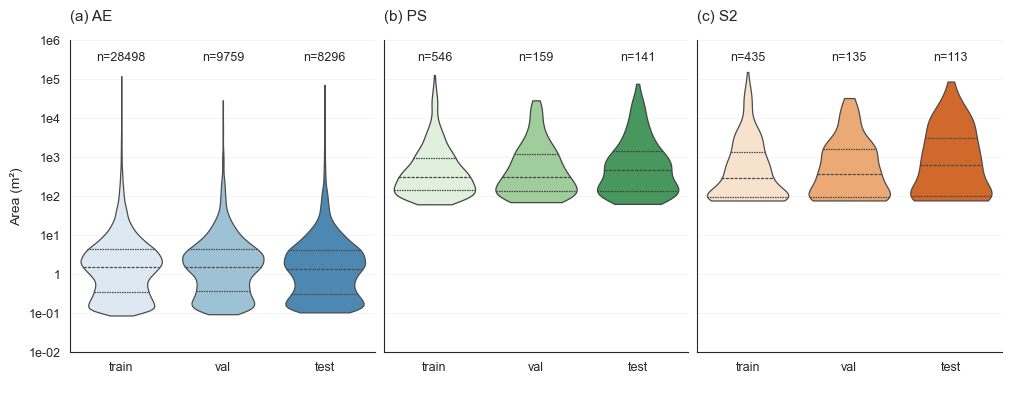

Saved plots: figs\area_violins_quartiles_countnorm_m2ticks.pdf and figs\area_violins_quartiles_countnorm_m2ticks.png
Saved: \\smb.isipd.dmawi.de\projects\p_planetdw\data\methods_test\training\AE\training_areas_with_split.gpkg


In [ ]:
import json
from pathlib import Path
import re
from typing import Optional, List

import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.transforms import blended_transform_factory
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Patch, Rectangle
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerBase

import seaborn as sns  # kept for consistent base style (but we use matplotlib boxplots)


# ----------------------------
# USER OPTIONS (paper version)
# ----------------------------
# Toggle jittered sample points overlay
PLOT_POINTS = True

# Toggle sensor legend (mini boxplots)
PLOT_SENSOR_LEGEND = True

# Leave empty => draw an empty PS subplot (but keep the 3-panel layout)
LABELS_PS = ""

# (kept for compatibility; not used for boxplots)
BW_ADJUST = 1.0

TEXTOFF = 0.90

# Match your reference boxplot scatter overlay style
POINT_ALPHA = 0.5
POINT_SIZE = 5
POINT_EDGE_LW = 0.3
JITTER_SD = 0.03
RNG = np.random.default_rng(0)  # deterministic jitter


# ----------------------------
# PALETTE OPTIONS (CHOOSABLE CONSTANTS)
# ----------------------------
PANEL_ORDER = ["AE", "PS", "S2"]

MODALITY_CMAPS = {
    "AE": "Blues",
    "PS": "Greens",
    "S2": "Oranges",
}

PALETTE_SHADE_MIN = 0.15
PALETTE_SHADE_MAX = 0.65

SPLIT_ORDER = ["training", "validation", "testing"]


# ----------------------------
# Paths
# ----------------------------
TRAINING_AREAS = r"N:\isipd\projects\p_planetdw\data\methods_test\training\AE\training_areas.gpkg"

LABELS_S2 = r"N:\isipd\projects\p_planetdw\data\methods_test\training\S2\labels_S2_exp.gpkg"
LABELS_AE = r"N:\isipd\projects\p_planetdw\data\methods_test\training\AE\labels_AE.gpkg"
LABELS_PS = r"N:\isipd\projects\p_planetdw\data\methods_test\training\PS\labels_PS.gpkg"

DATA_SPLIT_AA = r"N:\isipd\projects\p_planetdw\data\methods_test\preprocessed\AE\aa_frames_list.json"

FIG_DIR = Path("figs")
FIG_DIR.mkdir(parents=True, exist_ok=True)
OUT_PDF = FIG_DIR / "area_boxplots_m2ticks.pdf"
OUT_PNG = FIG_DIR / "area_boxplots_m2ticks.png"

OUT_TRAINING_AREAS_SPLIT = (
    r"\\smb.isipd.dmawi.de\projects\p_planetdw\data\methods_test\training\AE\training_areas_with_split.gpkg"
)


# ----------------------------
# Helpers
# ----------------------------
def safe_read_labels(path: str, source: str) -> Optional[gpd.GeoDataFrame]:
    """Read a label file if path is non-empty. Return None if empty or read fails."""
    if path is None or str(path).strip() == "":
        return None
    try:
        gdf = gpd.read_file(path)
        if gdf is None or len(gdf) == 0:
            return None
        gdf = gdf.copy()
        gdf["source"] = source
        return gdf
    except Exception as e:
        print(f"[WARN] Could not read {source} labels from: {path}\n       {e}")
        return None


def make_valid(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """Best-effort geometry validity fix (works well with shapely>=2)."""
    gdf = gdf.copy()
    try:
        gdf["geometry"] = gdf.geometry.make_valid()
    except Exception:
        pass
    return gdf


def sci_compact(x: float) -> str:
    """Compact scientific formatting for tick labels: 1e+03 -> 1e3."""
    if not np.isfinite(x) or x <= 0:
        return ""
    s = f"{x:.0e}"  # e.g. 1e+03
    s = s.replace("e+0", "e").replace("e+", "e").replace("e0", "")
    if re.fullmatch(r"-?\d+e0", s):
        s = s.replace("e0", "")
    return s


def apply_axes_frame_like_reference(ax):
    """Match the 'boxed frame' look of your reference figure."""
    for side in ["left", "right", "top", "bottom"]:
        ax.spines[side].set_visible(True)
        ax.spines[side].set_linewidth(0.8)
        ax.spines[side].set_color("black")

    ax.tick_params(axis="x", labelsize=6.5, pad=2, direction="out", length=3, width=0.8)
    ax.tick_params(axis="y", labelsize=7, pad=2, direction="out", length=3, width=0.8)

    ax.grid(axis="y", alpha=0.18, linestyle="--", linewidth=0.4)
    ax.set_axisbelow(True)


def empty_panel(ax, title: str, ns: List[int], ylabel: Optional[str] = None):
    ax.set_title(title, fontsize=9, fontweight="bold", pad=8)  # centered like reference
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=8)

    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels(["train", "val", "test"])
    ax.set_xlabel("")

    # n labels centered above each category
    trans = blended_transform_factory(ax.transData, ax.transAxes)
    for i, n in enumerate(ns, start=1):
        ax.text(
            i, TEXTOFF, f"n={n}",
            transform=trans, ha="center", va="bottom",
            fontsize=9, clip_on=False
        )

    apply_axes_frame_like_reference(ax)
    ax.set_xlim(0.5, 3.5)
    ax.text(0.5, 0.5, "No data", transform=ax.transAxes,
            ha="center", va="center", alpha=0.6)


def colored_boxplot_with_points(ax, data_by_split, split_order, split_palette, title, ylabel=None, ns=None):
    """
    Boxplots + optional jittered points, styled to match your reference boxplot figure
    (full frame, thin black lines, alpha boxes, faint dashed y-grid).
    """
    data = [data_by_split.get(sp, np.array([])) for sp in split_order]
    labels = ["train", "val", "test"]

    bp = ax.boxplot(
        data,
        labels=labels,
        patch_artist=True,
        vert=True,
        showfliers=False,
        widths=0.6
    )

    # color each box by split shade
    for box, sp in zip(bp["boxes"], split_order):
        box.set_facecolor(split_palette.get(sp, "#dddddd"))
        box.set_edgecolor("black")
        box.set_linewidth(0.8)
        box.set_alpha(0.75)

    # style elements (match reference)
    for line in bp["whiskers"]:
        line.set_color("black")
        line.set_linewidth(0.8)
    for line in bp["caps"]:
        line.set_color("black")
        line.set_linewidth(0.8)
    for line in bp["medians"]:
        line.set_color("black")
        line.set_linewidth(1.2)

    # jittered points (toggle)
    if PLOT_POINTS:
        for i, sp in enumerate(split_order, start=1):
            vals = data_by_split.get(sp, np.array([]))
            if vals is None or len(vals) == 0:
                continue
            x_pos = RNG.normal(loc=i, scale=JITTER_SD, size=len(vals))
            ax.scatter(
                x_pos, vals,
                alpha=POINT_ALPHA,
                s=POINT_SIZE,
                color=split_palette.get(sp, "#dddddd"),
                edgecolors="black",
                linewidth=POINT_EDGE_LW,
                zorder=3
            )

    ax.set_title(title, fontsize=9, fontweight="bold", pad=8)  # centered
    ax.set_xlabel("")
    ax.set_ylabel(ylabel if ylabel else "", fontsize=8)

    apply_axes_frame_like_reference(ax)
    ax.set_xlim(0.5, 3.5)
    ax.margins(x=0.02)

    # n labels above each category
    if ns is not None:
        trans = blended_transform_factory(ax.transData, ax.transAxes)
        for i, n in enumerate(ns, start=1):
            ax.text(
                i, TEXTOFF, f"n={n}",
                transform=trans, ha="center", va="bottom",
                fontsize=9, clip_on=False
            )


# --- Custom legend handler for mini boxplots (like your model-comparison figure) ---
class BoxplotHandler(HandlerBase):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        box_width = width * 0.65
        box_height = height * 0.50
        x_center = xdescent + width / 2
        y_center = ydescent + height / 2

        # box
        box = Rectangle(
            (x_center - box_width / 2, y_center - box_height / 2),
            box_width, box_height,
            facecolor=orig_handle.get_facecolor(),
            edgecolor="black",
            linewidth=0.8,
            alpha=0.75,
            transform=trans
        )

        # median
        median = Line2D(
            [x_center - box_width / 2, x_center + box_width / 2],
            [y_center, y_center],
            color="black",
            linewidth=1.2,
            transform=trans
        )

        # whiskers
        whisker_top = Line2D(
            [x_center, x_center],
            [y_center + box_height / 2, y_center + box_height / 2 + height * 0.18],
            color="black",
            linewidth=0.8,
            transform=trans
        )
        whisker_bottom = Line2D(
            [x_center, x_center],
            [y_center - box_height / 2, y_center - box_height / 2 - height * 0.18],
            color="black",
            linewidth=0.8,
            transform=trans
        )

        return [box, median, whisker_top, whisker_bottom]


# ----------------------------
# Load labels (PS optional)
# ----------------------------
labels_s2 = safe_read_labels(LABELS_S2, "S2")
labels_ae = safe_read_labels(LABELS_AE, "AE")
labels_ps = safe_read_labels(LABELS_PS, "PS")  # None if empty

loaded = [g for g in (labels_s2, labels_ae, labels_ps) if g is not None]
if not loaded:
    raise RuntimeError("No label files could be loaded (S2/AE/PS).")

# Harmonize CRS across loaded layers
base_crs = loaded[0].crs
for i in range(len(loaded)):
    if loaded[i].crs != base_crs:
        loaded[i] = loaded[i].to_crs(base_crs)

all_labels = gpd.GeoDataFrame(pd.concat(loaded, ignore_index=True), crs=base_crs)

# ----------------------------
# Load training areas and align CRS
# ----------------------------
training_areas = gpd.read_file(TRAINING_AREAS)
print(f"found {len(training_areas)} training areas")

if training_areas.crs != all_labels.crs:
    training_areas = training_areas.to_crs(all_labels.crs)

training_areas = training_areas.copy()
training_areas["training_area_id"] = training_areas.index.astype(int)

all_labels = make_valid(all_labels)
training_areas = make_valid(training_areas)

# Clip labels to training areas
all_labels_clipped = gpd.clip(all_labels, training_areas)

# Spatial join to attach training_area_id
all_labels_joined = gpd.sjoin(
    all_labels_clipped,
    training_areas[["training_area_id", "geometry"]],
    how="left",
    predicate="intersects",
)

# If overlapping training areas create duplicates, keep first match
if all_labels_joined.index.duplicated().any():
    all_labels_joined = all_labels_joined[~all_labels_joined.index.duplicated(keep="first")]

# Remove sjoin artifact columns
all_labels = all_labels_joined.drop(
    columns=[c for c in all_labels_joined.columns if c.startswith("index_")],
    errors="ignore",
)
all_labels["training_area_id"] = all_labels["training_area_id"].astype("Int64")

# ----------------------------
# Load split lists and assign split
# ----------------------------
with open(DATA_SPLIT_AA, "r") as f:
    aa_frames = json.load(f)

training_frames_list = aa_frames["training_frames"]
validation_frames_list = aa_frames["validation_frames"]
testing_frames_list = aa_frames["testing_frames"]

all_labels["data_split"] = "unknown"
all_labels.loc[all_labels["training_area_id"].isin(training_frames_list), "data_split"] = "training"
all_labels.loc[all_labels["training_area_id"].isin(validation_frames_list), "data_split"] = "validation"
all_labels.loc[all_labels["training_area_id"].isin(testing_frames_list), "data_split"] = "testing"

print(all_labels["data_split"].value_counts(dropna=False))

# ----------------------------
# Compute area (UTM => m²) and log10 transform for plotting
# ----------------------------
all_labels["area_m2"] = all_labels.geometry.area.astype(float)
all_labels.loc[all_labels["area_m2"] <= 0, "area_m2"] = np.nan
all_labels["log10_area_m2"] = np.log10(all_labels["area_m2"])

split_order = SPLIT_ORDER
sources_fixed = PANEL_ORDER

# user requested: no (a)(b)(c) labels
panel_labels = ["", "", ""]

df_plot = all_labels.loc[
    all_labels["data_split"].isin(split_order) & np.isfinite(all_labels["log10_area_m2"]),
    ["source", "data_split", "log10_area_m2"],
].copy()

vals = df_plot["log10_area_m2"].to_numpy()
if len(vals) == 0:
    raise RuntimeError("No valid areas to plot (check geometry / split assignment).")

# Global y-lims in log10 units
ymin = float(np.nanmin(vals))
ymax = float(np.nanmax(vals))
pad = 0.06 * max(1e-6, (ymax - ymin))
ymin_plot, ymax_plot = ymin - pad, ymax + pad

# Decade ticks (labels will be shown in m²)
kmin = int(np.floor(ymin_plot))
kmax = int(np.ceil(ymax_plot))
decade_ticks = np.arange(kmin, kmax + 1, 1)

# ----------------------------
# Plot styling (match your reference boxplot look)
# ----------------------------
mpl.rcParams.update({
    "font.size": 8,
    "axes.titlesize": 9,
    "axes.labelsize": 8,
    "xtick.labelsize": 6.5,
    "ytick.labelsize": 7,
    "axes.linewidth": 0.8,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})
sns.set_style("white")  # keep clean background; we draw our own frame/grid

# ----------------------------
# MODALITY-SPECIFIC PALETTES (train/val/test shades)
# ----------------------------
palettes_by_source = {}
for src in sources_fixed:
    cmap_name = MODALITY_CMAPS.get(src, "Greys")
    cmap = get_cmap(cmap_name)
    shades = cmap(np.linspace(PALETTE_SHADE_MIN, PALETTE_SHADE_MAX, 3))
    palettes_by_source[src] = {
        "training": shades[0],
        "validation": shades[1],
        "testing": shades[2],
    }

# ----------------------------
# Figure layout (match the "row of small panels" layout)
# ----------------------------
fig = plt.figure(figsize=(10.5, 3))

# Leave room on the right for the legend (like your reference boxplot figure)
right_margin = 0.83 if PLOT_SENSOR_LEGEND else 0.95

gs = fig.add_gridspec(
    1, 3,
    hspace=0,
    wspace=0.35,
    left=0.06,
    right=right_margin,
    top=0.88,
    bottom=0.22
)
axes = [fig.add_subplot(gs[0, j]) for j in range(3)]

# ----------------------------
# Draw boxplots per panel
# ----------------------------
for ax, source, plab in zip(axes, sources_fixed, panel_labels):
    sub = df_plot[df_plot["source"] == source]
    title = f"{plab} {source}"

    ns = [int((sub["data_split"] == sp).sum()) for sp in split_order]

    if sub.empty:
        empty_panel(ax, title, ns, ylabel="Area (m²)" if ax is axes[0] else None)
        ax.set_ylim(ymin_plot, ymax_plot)
        ax.set_yticks(decade_ticks)
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: sci_compact(10.0 ** y)))
        continue

    data_by_split = {
        sp: sub.loc[sub["data_split"] == sp, "log10_area_m2"].dropna().to_numpy()
        for sp in split_order
    }

    colored_boxplot_with_points(
        ax=ax,
        data_by_split=data_by_split,
        split_order=split_order,
        split_palette=palettes_by_source[source],
        title=title,
        ylabel="Area (m²)" if ax is axes[0] else None,
        ns=ns
    )

    # Y axis: plotted in log10-space, but labeled in m²
    ax.set_ylim(ymin_plot, ymax_plot)
    ax.set_yticks(decade_ticks)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: sci_compact(10.0 ** y)))

# ----------------------------
# Sensor legend (mini boxplots) — AE / PS / S2
# ----------------------------
if PLOT_SENSOR_LEGEND:
    # pick a representative shade per sensor (use "validation" mid shade)
    sensor_colors = {
        src: palettes_by_source[src]["validation"] for src in sources_fixed if src in palettes_by_source
    }

    legend_handles = [
        Patch(facecolor=sensor_colors[src], edgecolor="black", label=src, alpha=0.75, linewidth=0.8)
        for src in sources_fixed if src in sensor_colors
    ]

    fig.legend(
        handles=legend_handles,
        loc="center left",
        bbox_to_anchor=(right_margin + 0.01, 0.5),  # just to the right of plots
        frameon=False,
        fontsize=8,
        handler_map={Patch: BoxplotHandler()},
        handlelength=2.0,
        handleheight=1.5,
        title="Sensor",
        title_fontsize=8,
    )

fig.savefig(OUT_PDF, bbox_inches="tight", dpi=300)
fig.savefig(OUT_PNG, dpi=450, bbox_inches="tight")
plt.show()

print(f"Saved plots: {OUT_PDF} and {OUT_PNG}")

# ----------------------------
# Save training areas with split attribute
# ----------------------------
training_areas_out = training_areas.copy()
training_areas_out["data_split"] = "unknown"
training_areas_out.loc[training_areas_out["training_area_id"].isin(training_frames_list), "data_split"] = "training"
training_areas_out.loc[training_areas_out["training_area_id"].isin(validation_frames_list), "data_split"] = "validation"
training_areas_out.loc[training_areas_out["training_area_id"].isin(testing_frames_list), "data_split"] = "testing"

training_areas_out.to_file(OUT_TRAINING_AREAS_SPLIT)
print(f"Saved: {OUT_TRAINING_AREAS_SPLIT}")


In [ ]:
import os
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

results_dir = r"N:\isipd\projects\p_planetdw\git\DriftwoodMappingBenchmark\analysis\result_safe"
csv_list = [os.path.join(results_dir, f) for f in os.listdir(results_dir) if f.endswith(".csv")]

combined_df = pd.concat((pd.read_csv(p) for p in csv_list), ignore_index=True)

# --- color map (from your figure) ---
MODEL_COLORS = {
    "UNet": "#c27ba0",
    "Swin": "#e06666",
    "FN":   "#ffd966",
}

def infer_model(run_name: str) -> str:
    s = str(run_name).lower()
    if "terramind" in s or "terraminf" in s:   # <- your rule
        return "FN"
    if "unet" in s:
        return "UNet"
    if "swin" in s:
        return "Swin"
    if "fn" in s:
        return "FN"
    return "Other"

# order of groups on x-axis
run_names = sorted(combined_df["run_name"].dropna().unique())

def grouped_data(col):
    return [
        combined_df.loc[combined_df["run_name"] == rn, col].dropna().values
        for rn in run_names
    ]

def colored_boxplot(ax, col, title):
    data = grouped_data(col)
    bp = ax.boxplot(data, labels=run_names, patch_artist=True, vert=True)

    # color each box by model (parsed from run_name)
    for box, rn in zip(bp["boxes"], run_names):
        model = infer_model(rn)
        box.set_facecolor(MODEL_COLORS.get(model, "#dddddd"))
        box.set_edgecolor("black")
        box.set_linewidth(1.0)
        box.set_alpha(0.9)

    # keep lines readable
    for k in ("whiskers", "caps", "medians"):
        for line in bp[k]:
            line.set_color("black")
            line.set_linewidth(1.0)

    ax.set_title(title)
    ax.set_xlabel("Run")
    ax.set_ylabel(title)
    ax.tick_params(axis="x", rotation=45)

# --- subplots: 3x2 grid ---
fig, axs = plt.subplots(3, 2, figsize=(14, 12))

colored_boxplot(axs[0, 0], "IoU", "IoU")
colored_boxplot(axs[0, 1], "dice_coef", "Dice Coefficient")
colored_boxplot(axs[1, 0], "normalized_surface_distance", "Normalized Surface Distance")
colored_boxplot(axs[1, 1], "mean_epistemic_uncertainty", "Mean Epistemic Uncertainty")
colored_boxplot(axs[2, 0], "mean_aleatoric_uncertainty", "Mean Aleatoric Uncertainty")
axs[2, 1].axis("off")

# legend (models)
legend_handles = [Patch(facecolor=c, edgecolor="black", label=m) for m, c in MODEL_COLORS.items()]
fig.legend(handles=legend_handles, loc="upper center", ncol=3, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
